## We used BERT for processing repos readme, description and name. Then we used k-means and dendrogram for unsupervised learning. To run this code, we need to import what we have extracted, which is the file named "ethereum_repos_extracted_text_cleaned.json"

In [ ]:
! pip install spacy
! python -m spacy download en_core_web_sm
! pip install gensim
! pip install scikit-learn
! pip install transformers torch
! pip install kneed
! pip install scipy matplotlib

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import smart_open
from gensim.parsing.preprocessing import strip_punctuation, remove_stopwords
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spacy
import torch
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# use spacy for text preprocessing
spacy.cli.download('en_core_web_sm')

nlp = spacy.load('en_core_web_sm')

json_file_path = '/content/ethereum_repos_extracted_text_cleaned.json'

with open(json_file_path, 'r') as file:
  json_data = json.load(file)

l = list()
for repo in json_data:

  text = repo["name"]+" " + (repo["desc"] or " ")
  text = remove_stopwords(strip_punctuation(text))
  l.append(text)

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# use "bert-base-uncased" for embedding
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

inputs = tokenizer(l, padding=True, truncation=True, max_length=128, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

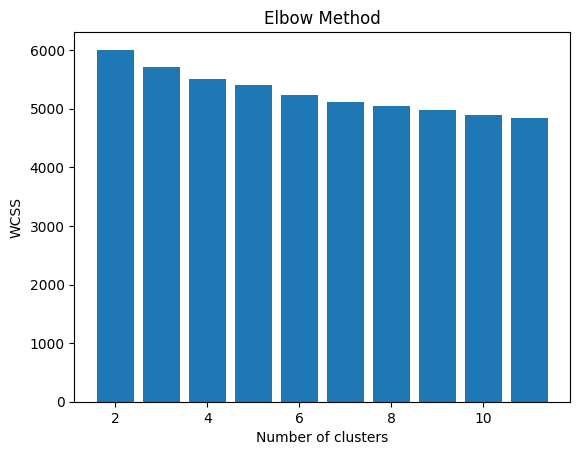

In [ ]:
# used elbow method for determining the number of clusters
wcss = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)
plt.bar(range(2, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# find knee point to precisely determine cluster number
from kneed import KneeLocator

k_values = list(range(2, 12))

kneedle = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')

elbow_point = kneedle.elbow

print(f"The elbow point is at cluster number: {elbow_point}")


The elbow point is at cluster number: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


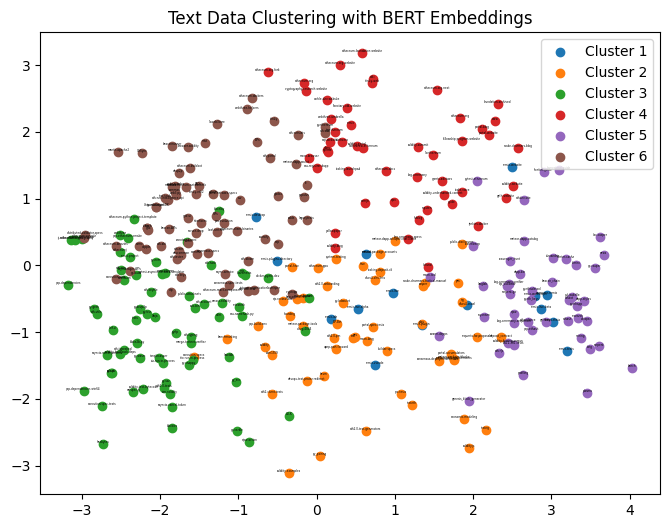

In [ ]:
# PCA for dimentionality reduction for visualization
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
for i in range(num_clusters):
  plt.scatter(reduced_embeddings[labels == i, 0], reduced_embeddings[labels == i, 1], label=f"Cluster {i+1}")

for index, coord in enumerate(reduced_embeddings):
  x = coord[0]
  y = coord[1]
  plt.text(x, y, json_data[index]["name"], va='bottom', ha='center', fontdict={'size': 2})

plt.title("Text Data Clustering with BERT Embeddings")
plt.legend()
plt.savefig("textdata.pdf")

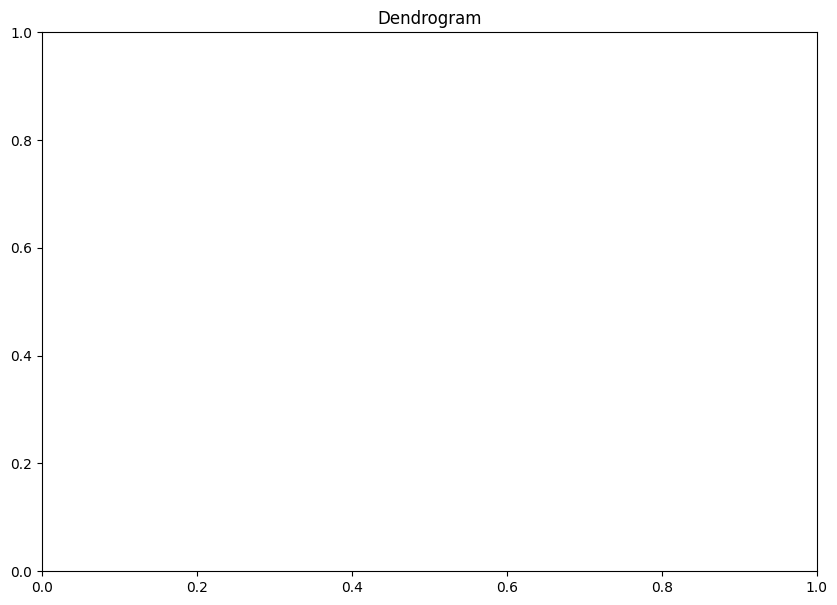

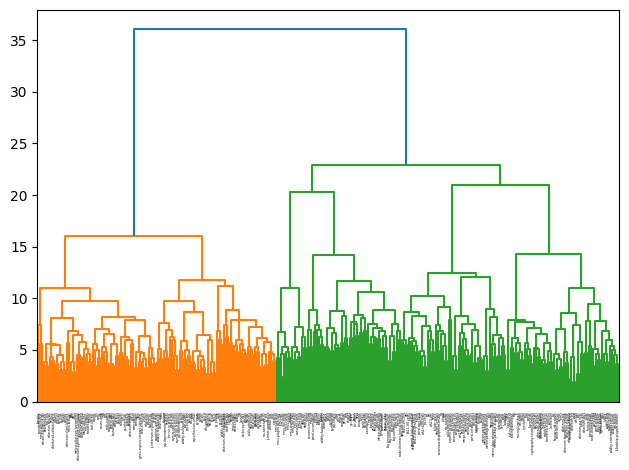

In [ ]:
# Plotting the dendrogram
Z = linkage(embeddings, 'ward')
plt.figure(figsize=(10, 7))
plt.title("Dendrogram")
fig, ax = plt.subplots()
repo_names = [repo["name"] for repo in json_data]
dendrogram(
    Z,
    labels=repo_names,
    leaf_rotation=90,
    leaf_font_size=2,
)
fig.tight_layout()
plt.savefig('/content/dendrogram.pdf')
plt.show()
